# **Instalar dependencias**
Primero, instalamos las bibliotecas necesarias para el proyecto. Incluyen earthengine-api para Google Earth Engine, geemap para análisis geoespacial, y folium para la creación de mapas interactivos.


In [1]:
!pip install earthengine-api geemap folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00


# **Montar Google Drive**

Montamos Google Drive para guardar los resultados, como datos exportados o archivos CSV generados.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importar bibliotecas**

Importamos las bibliotecas necesarias para el procesamiento de datos, análisis geoespacial y operaciones con Google Earth Engine.

In [3]:
import ee
import geemap
import math
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape

# **Autenticar e inicializar Earth Engine**

Autenticamos nuestra cuenta de Google Earth Engine (GEE) e inicializamos la sesión. Asegurarse de que el ID del proyecto de GEE esté configurado correctamente.

El ID del proyecto se encuentra en la esquina superior derecha en GEE como se muestra a continuacion:

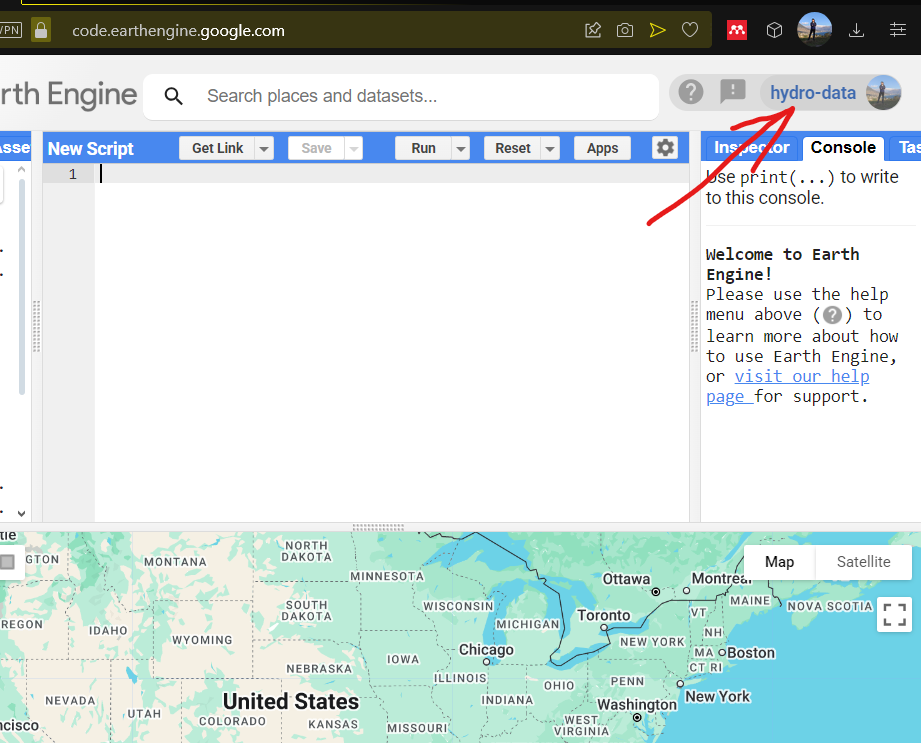

In [4]:
ee.Authenticate()
ee.Initialize(project='hydro-data') ##El ID del proyecto se encuentra en la esquina superior derecha en GEE

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


# **Cargar conjuntos de datos**

Cargamos los conjuntos de datos geoespaciales, como las cuencas (HydroBASINS), los datos de elevación (SRTM), las redes fluviales y el área de estudio personalizada.

En este caso se carga el area de estudio para Ecuador solamente como guia ya que el poligono se puede trazar en cualquier parte del mundo.

In [5]:
# Cargar conjuntos de datos
cuencas_hidro = ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_8')
srtm = ee.Image('CGIAR/SRTM90_V4')
rios_hidro = ee.FeatureCollection('WWF/HydroSHEDS/v1/FreeFlowingRivers')
area_de_estudio = ee.FeatureCollection('projects/ee-carsk89322/assets/area_de_estudio')


# **Funciones**

In [6]:
# Función para redondear números a dos decimales
def redondear_a_dos_decimales(numero):
    return ee.Number(numero).multiply(100).round().divide(100)

In [7]:
# Definir cálculo de métricas hidrológicas
def calcular_metricas(cuencas, rios, dem):
    pendiente = ee.Terrain.slope(dem)

    def calcular(feature):
        geom_cuenca = feature.geometry()
        area = redondear_a_dos_decimales(geom_cuenca.area().divide(1e6))
        perimetro = redondear_a_dos_decimales(geom_cuenca.perimeter().divide(1000))
        factor_forma = redondear_a_dos_decimales(perimetro.pow(2).divide(area.multiply(ee.Number(4).multiply(ee.Number(math.pi)))))
        centroide = geom_cuenca.centroid()
        centroide_x = centroide.coordinates().get(0)
        centroide_y = centroide.coordinates().get(1)
        coef_compacidad = redondear_a_dos_decimales(ee.Number(0.282).multiply(perimetro).divide(area.sqrt()))
        radio_circularidad = redondear_a_dos_decimales(ee.Number(4).multiply(ee.Number(math.pi)).multiply(area).divide(perimetro.pow(2)))
        estadisticas_pendiente = pendiente.reduceRegion(
            reducer=ee.Reducer.mean().combine(
                reducer2=ee.Reducer.minMax(),
                sharedInputs=True
            ),
            geometry=geom_cuenca,
            scale=90,
            maxPixels=1e13
        )
        pendiente_media = redondear_a_dos_decimales(estadisticas_pendiente.get('slope_mean'))
        pendiente_min = redondear_a_dos_decimales(estadisticas_pendiente.get('slope_min'))
        pendiente_max = redondear_a_dos_decimales(estadisticas_pendiente.get('slope_max'))
        tiempo_concentracion = redondear_a_dos_decimales(area.pow(0.385).multiply(perimetro.pow(0.15)).multiply(0.01947))

        return feature.set({
            'HYBAS_ID': feature.get('HYBAS_ID'),
            'area_km2': area,
            'perimetro_km': perimetro,
            'factor_forma': factor_forma,
            'pendiente_media': pendiente_media,
            'pendiente_min': pendiente_min,
            'pendiente_max': pendiente_max,
            'tiempo_concentracion_hr': tiempo_concentracion,
            'centroide_x': centroide_x,
            'centroide_y': centroide_y,
            'coef_compacidad': coef_compacidad,
            'radio_circularidad': radio_circularidad
        })

    return cuencas.map(calcular)


Esta función realiza un análisis de redes en los datos de los ríos de cada cuenca. Usa la biblioteca networkx para calcular el camino más largo (longest path) dentro de la red fluvial.

In [8]:
# Función para análisis de redes
def calculate_longest_path(rios_df):
    G = nx.DiGraph()
    for _, row in rios_df.iterrows():
        G.add_edge(row['NOID'], row['NDOID'], length=row['LENGTH_KM'])
    longest_path = nx.dag_longest_path(G, weight='length')
    total_length = sum(nx.get_edge_attributes(G, 'length')[edge] for edge in nx.utils.pairwise(longest_path))
    return longest_path, total_length


# **Configurar mapa interactivo**

Creamos un mapa interactivo para visualizar el área de estudio, las cuencas, la elevación y los ríos. Este mapa permite a los usuarios dibujar polígonos para definir un área de análisis personalizada.


In [9]:
# Configurar mapa interactivo
Map = geemap.Map(center=[0, 0], zoom=2)
Map.add_basemap('SATELLITE')
Map.addLayer(area_de_estudio, {'color': 'red'}, 'Área de Estudio')
Map.addLayer(cuencas_hidro, {'color': 'blue'}, 'HydroBASINS Nivel 8')
Map.addLayer(srtm, {'min': 0, 'max': 3000, 'palette': ['blue', 'green', 'yellow', 'brown', 'white']}, 'SRTM')
Map.addLayer(rios_hidro, {'color': 'cyan'}, 'Ríos Libres')
Map.add_draw_control()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Una vez que se ha dibujado el poligono en el mapa interactivo anterior proceder con el siguiente paso:

# **Exportar datos y calcular métricas**

Exportamos datos a GeoJSON, realizamos cálculos de métricas hidrológicas y guardamos los resultados en un archivo CSV.

***Nota importante:***

**Probablemente de un error mostrando que el archivo no existe, esto ocurre a que la ejecucion es realizada como una tarea en GEE por lo cual se puede demorar en funcion del area a calcularse. La solucion es esperar unos minutos y volver a ejecutar el codigo.**

Para ver el estado de la tarea se puede ingresar a: [Google Task Manager](https://code.earthengine.google.com/tasks)

In [10]:
drawn_feature = Map.draw_last_feature
# Procesar y analizar redes fluviales
if drawn_feature:
    # Definir el área dibujada
    poligono_dibujado = ee.Geometry(drawn_feature.geometry())
    cuencas_intersec = cuencas_hidro.filterBounds(poligono_dibujado)

    # Exportar ríos a GeoJSON
    output_path = 'rivers'
    rios_hidro_personalizados = rios_hidro.filterBounds(cuencas_intersec.geometry())
    task = ee.batch.Export.table.toDrive(
        collection=rios_hidro_personalizados,
        description='ExportRivers',
        fileFormat='GeoJSON',
        fileNamePrefix=output_path
    )
    task.start()
    print("Exportación iniciada. Revisa las tareas de Earth Engine.")

    # Esperar exportación y cargar datos de ríos
    rios_geojson_path = '/content/drive/MyDrive/rivers.geojson'
    rios_df = gpd.read_file(rios_geojson_path)

    # Análisis de redes y cálculos
    longest_path_data = []
    for basin in cuencas_intersec.getInfo()['features']:
        basin_geom = shape(basin['geometry'])
        basin_id = basin['properties']['HYBAS_ID']

        rios_basin = rios_df[rios_df.geometry.intersects(basin_geom)]
        longest_path, total_length = calculate_longest_path(rios_basin)

        longest_path_data.append({
            'HYBAS_ID': basin_id,
            'Longest_Path_km': total_length
        })

    # Combinar con métricas hidrológicas
    metricas_cuenca = calcular_metricas(cuencas_intersec, rios_hidro_personalizados, srtm)
    metricas_cuenca_list = metricas_cuenca.getInfo()
    metrics_df = pd.DataFrame([f['properties'] for f in metricas_cuenca_list['features']])
    longest_path_df = pd.DataFrame(longest_path_data)

    # Guardar resultados combinados
    combined_df = metrics_df.merge(longest_path_df, on='HYBAS_ID', how='left')
    combined_csv_path = '/content/drive/MyDrive/basin_metrics_with_network.csv' #Ruta donde guardar el Archivo en Google Drive
    combined_df.to_csv(combined_csv_path, index=False)
    print(f"Resultados guardados como '{combined_csv_path}'.")
else:
    print('No se ha dibujado ningún polígono.')


Exportación iniciada. Revisa las tareas de Earth Engine.
Resultados guardados como '/content/drive/MyDrive/basin_metrics_with_network.csv'.


# **VIsualizacion de Resultados**


Pasar el mouse por la cuenca deseada.

In [13]:
# Visualizar cuencas, métricas y camino más largo
import folium

# Crear un mapa base
mapa_resultados = folium.Map(
    location=[-1.5, -78], zoom_start=7,
    tiles='CartoDB positron'  # light
)
# Iterar sobre cada cuenca seleccionada
for basin in cuencas_intersec.getInfo()['features']:
    basin_geom = shape(basin['geometry'])
    basin_id = basin['properties']['HYBAS_ID']

    # Filtrar ríos dentro de la cuenca
    rios_basin = rios_df[rios_df.geometry.intersects(basin_geom)]

    # Obtener las métricas calculadas para la cuenca
    metrics = next(
        item for item in metricas_cuenca_list['features'] if item['properties']['HYBAS_ID'] == basin_id
    )['properties']

    # Obtener el camino más largo
    longest_path, total_length = calculate_longest_path(rios_basin)
    tramo_principal_km = round(total_length, 2)

    # Crear un tooltip con las métricas y el tramo principal
    tooltip_text = (
        f"HYBAS_ID: {metrics['HYBAS_ID']}<br>"
        f"Área (km²): {metrics['area_km2']}<br>"
        f"Perímetro (km): {metrics['perimetro_km']}<br>"
        f"Factor de forma: {metrics['factor_forma']}<br>"
        f"Pendiente media (%): {metrics['pendiente_media']}<br>"
        f"Pendiente mínima (%): {metrics['pendiente_min']}<br>"
        f"Pendiente máxima (%): {metrics['pendiente_max']}<br>"
        f"Tiempo de concentración (hr): {metrics['tiempo_concentracion_hr']}<br>"
        f"Coeficiente de compacidad: {metrics['coef_compacidad']}<br>"
        f"Radio de circularidad: {metrics['radio_circularidad']}<br>"
        f"Tramo principal (km): {tramo_principal_km}"
    )

    # Añadir la cuenca al mapa con tooltip
    folium.GeoJson(
        basin_geom,
        style_function=lambda x: {'color': 'blue', 'fillOpacity': 0.1},
        tooltip=folium.Tooltip(tooltip_text),
        name=f'Cuenca {basin_id}'
    ).add_to(mapa_resultados)

    # Añadir los segmentos del camino más largo al mapa
    for edge in nx.utils.pairwise(longest_path):
        start_node = rios_basin[rios_basin['NOID'] == edge[0]].iloc[0]
        end_node = rios_basin[rios_basin['NDOID'] == edge[1]].iloc[0]

        # Crear el segmento del camino más largo
        segment = start_node.geometry

        folium.GeoJson(
            segment,
            style_function=lambda x: {'color': 'red', 'weight': 3},
            name=f'Tramo Principal en Cuenca {basin_id}'
        ).add_to(mapa_resultados)

# Añadir control de capas
folium.LayerControl().add_to(mapa_resultados)

# Mostrar el mapa


mapa_resultados
